In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Initialization

### Imports

In [2]:
import os
import sys
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

<IPython.core.display.Javascript object>

In [3]:
from data.transforms import HE_preprocess
from data.dataset import TileDataset, PredictFromImgDataset

from model_zoo.models import define_model

from utils.save import save_as_jit
from utils.plots import plot_global_pred, plot_thresh_scores

from training.train import fit
from training.predict import predict_entire_mask

<IPython.core.display.Javascript object>

In [4]:
from params import *

<IPython.core.display.Javascript object>

### Load

In [5]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + "df_images.csv")

<IPython.core.display.Javascript object>

## Data

In [6]:
viz_ds = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=True),
)

<IPython.core.display.Javascript object>

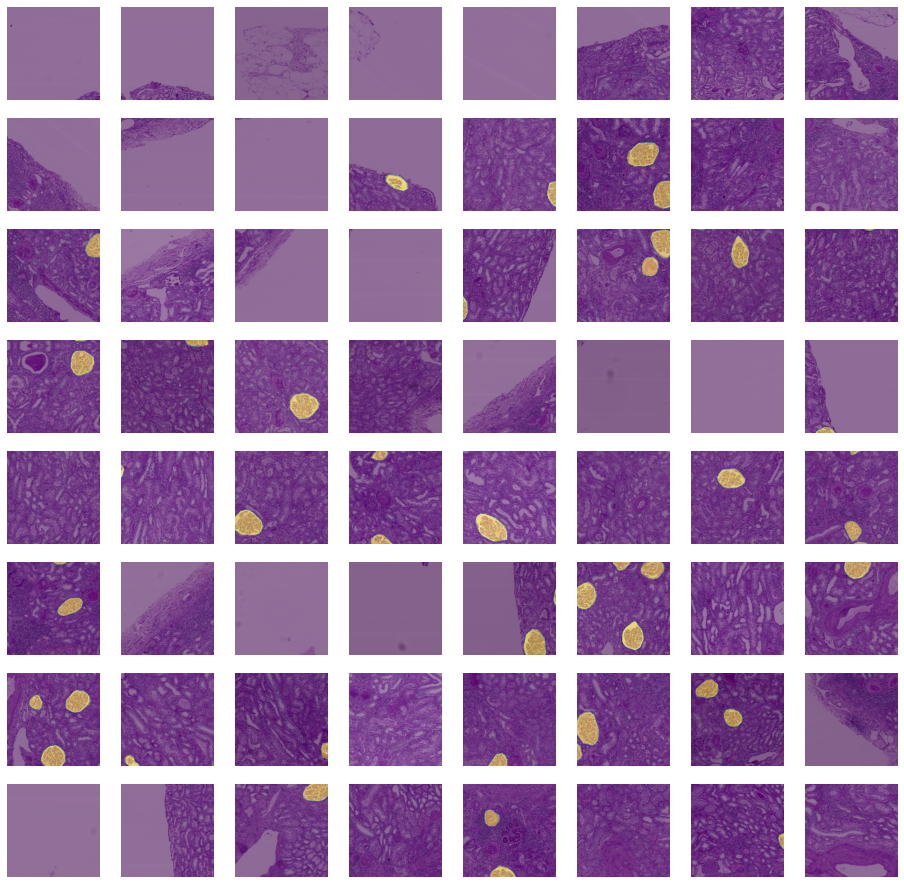

<IPython.core.display.Javascript object>

In [7]:
viz_dl = DataLoader(viz_ds, batch_size=64, shuffle=False)
imgs, masks = next(iter(viz_dl))

plt.figure(figsize=(16, 16))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img.permute(1, 2, 0).numpy()  # .astype(np.uint8)
    plt.subplot(8, 8, i + 1)
    plt.imshow(img)  # , vmin=0, vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.5)
    plt.axis("off")
    plt.subplots_adjust(wspace=None, hspace=None)

## Model

In [8]:
from training.lovasz import *

<IPython.core.display.Javascript object>

In [9]:
dataset = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=False),
)

<IPython.core.display.Javascript object>

In [10]:
model = define_model("Unet", "resnet18")

<IPython.core.display.Javascript object>

In [11]:
img, y = dataset[0]

<IPython.core.display.Javascript object>

In [12]:
pred = model(img.unsqueeze(0))

<IPython.core.display.Javascript object>

In [13]:
symmetric_lovasz(pred, y.unsqueeze(0))

tensor([6.3628], grad_fn=<DivBackward0>)

<IPython.core.display.Javascript object>

## Training

In [14]:
from training.main import k_fold

<IPython.core.display.Javascript object>

In [15]:
from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

<IPython.core.display.Javascript object>

In [16]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    img_dir = IMG_PATH
    mask_dir = MASK_PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    cv_column = "4fold"
    random_state = 0
    selected_folds = [0]  # [0, 1, 2, 3]

    # Model
    encoder = "se_resnext50_32x4d"  # resnext50_32x4d, "resnet18", "se_resnext50_32x4d"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    encoder_weights = "imagenet"
    num_classes = 1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    batch_size = 32
    epochs = 1
    swa_first_epoch = 40

    lr = 1e-3  # 5e-4 / 1e-3
    warmup_prop = 0.05
    val_bs = 32

    first_epoch_eval = 0

    # Inference
    overlap_factor = 4

<IPython.core.display.Javascript object>

In [17]:
DEBUG = True
log_folder = None

<IPython.core.display.Javascript object>


-------------   Fold 1 / 4  -------------

    -> 3482 training images
    -> 489 validation images
    -> 34523969 trainable parameters



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 01/01 	 lr=0.0e+00	 t=45s	loss=0.225	val_loss=0.089 	 dice=0.8407


/home/theo/venv/lib/python3.8/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


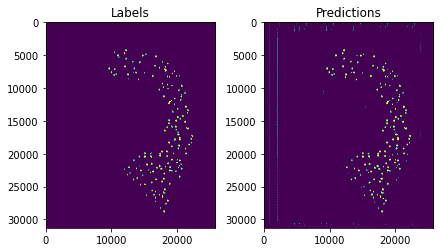

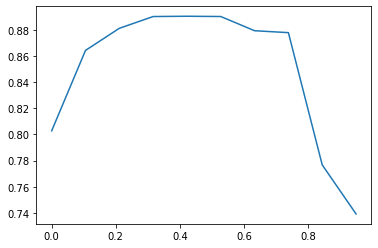

 50%|█████     | 1/2 [04:54<04:54, 294.48s/it]

Maximum dice: 0.890520434224622 with thresh 0.4222222222222222


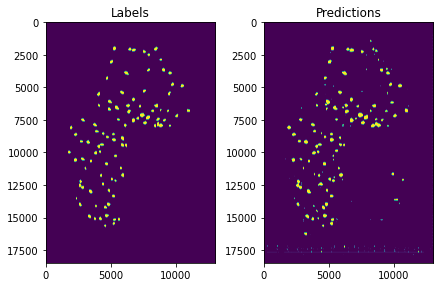

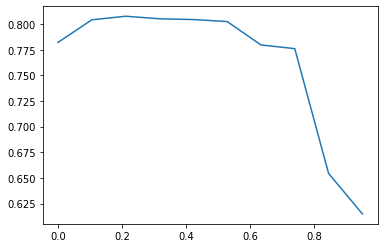

100%|██████████| 2/2 [06:25<00:00, 192.82s/it]

Maximum dice: 0.8075993227658731 with thresh 0.2111111111111111


<IPython.core.display.Javascript object>

In [18]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    df.to_csv(log_folder + "data.csv", index=False)
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold(Config, df, log_folder=log_folder)

In [22]:
np.linspace(0.3, 0.7, 5)

array([0.3, 0.4, 0.5, 0.6, 0.7])

<IPython.core.display.Javascript object>

In [22]:
df

,tile_name,fold,4fold
0,2f6ecfcdf_00063.png,0,0_1
1,2f6ecfcdf_00064.png,0,0_1
2,2f6ecfcdf_00065.png,0,0_1
3,2f6ecfcdf_00066.png,0,0_1
4,2f6ecfcdf_00085.png,0,0_1
...,...,...,...
3966,1e2425f28_00758.png,7,6_7
3967,1e2425f28_00759.png,7,6_7
3968,1e2425f28_00760.png,7,6_7
3969,1e2425f28_00761.png,7,6_7


<IPython.core.display.Javascript object>

In [20]:
encoder = "se_resnext50_32x4d"
decoder = "Unet"
plot_global = True
cv_column = "4fold"

cv_scores = []
for fold_nb in df_images[cv_column].unique():
    print("FOLD :", fold_nb)

    train_df = df_images[df_images[cv_column] != fold_nb].reset_index()
    val_df = df_images[df_images[cv_column] == fold_nb].reset_index()
    mask_names = val_df.tile_name.apply(lambda x: x.split("_")[0]).unique()

    train_dataset = TileDataset(
        train_df,
        IMG_PATH,
        MASK_PATH,
        transforms=HE_preprocess(augment=True, visualize=False),
    )
    val_dataset = TileDataset(
        val_df,
        IMG_PATH,
        MASK_PATH,
        transforms=HE_preprocess(augment=False, visualize=False),
    )

    model = define_model(decoder, encoder, num_classes=1, activation=None).to("cuda")
    meter, history = fit(
        model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        epochs=2,
        loss_name="BCEWithLogitsLoss",
        swa_first_epoch=40,
        batch_size=32,
    )
    cv_scores.append(history.dice.values[-1])
    px.line(history, x="epoch", y="dice").show()

    saving_path = "../models/"
    model_name = f"{encoder}_{decoder}_{tile_size}_{reduce_fac}_fold{fold_nb}"
    #     torch.save(model.state_dict(), os.path.join(saving_path, model_name+".pt")
    #     save_as_jit(model, saving_path, model_name, train_img_size=tile_size)
    if plot_global:
        for mask_name in tqdm(mask_names):
            print(f"predicting global image {mask_name}...")
            predict_dataset = PredictFromImgDataset(
                f"../input/train/{mask_name}.tiff",
                mask_name=mask_name,
                overlap_factor=4,
                reduce_factor=reduce_fac,
                transforms=HE_preprocess(augment=False, visualize=False),
            )

            global_pred = predict_entire_mask(predict_dataset, model, batch_size=16)
            plot_global_pred(mask=predict_dataset.mask, pred=global_pred > 0)
            thresholds, scores = plot_thresh_scores(
                mask=predict_dataset.mask, pred=global_pred
            )
            max_score_pos = np.argmax(scores)
            print(
                f"Maximum dice: {scores[max_score_pos]} with thresh {thresholds[max_score_pos]}"
            )
    break

print(f"Average CV : {np.mean(cv_scores)} (std : {np.std(cv_scores)})")

NameError: name 'df_images' is not defined

<IPython.core.display.Javascript object>